# PKPD_META 202: Hierarchical Linear Simulation

This notebook mirrors the toy hierarchical linear model described in `content/posts/pkpd/pkpd_meta-202.md`. We simulate internal patient-level data alongside external visit-level averages, then prepare Stan inputs for multiple inference strategies.

## Setup

Load the R packages used in the BAAD simulation scripts and set Stan options. The code below assumes `rstan` is configured; adjust the cores to suit your machine.

In [1]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(mvtnorm)
  library(rstan)
  library(posterior)
  library(bayesplot)
})

rstan_options(auto_write = TRUE)
options(mc.cores = max(2L, parallel::detectCores(logical = FALSE)))
set.seed(202502)


## Data-generating process

Section 4.1 fixes common population parameters $\mu_\alpha$, $\Sigma_\alpha$, $\beta$, and $\sigma_y$ while the external cohort receives a shift $\delta$ on the intercept and linear trend. The code block below records these constants.

In [2]:
params <- list(
  mu_alpha = c(0.5, -0.2),
  sigma_alpha = c(0.1, 0.1),
  beta = -0.1,
  sigma_y = 0.05,
  delta = c(0.1, 0.1)
)

design <- list(
  visits = seq(0, 1, length.out = 13),
  J_internal = 100L,
  J_external = 100L
)

str(params)
str(design)


List of 5
 $ mu_alpha   : num [1:2] 0.5 -0.2
 $ sigma_alpha: num [1:2] 0.1 0.1
 $ beta       : num -0.1
 $ sigma_y    : num 0.05
 $ delta      : num [1:2] 0.1 0.1
List of 3
 $ visits    : num [1:13] 0 0.0833 0.1667 0.25 0.3333 ...
 $ J_internal: int 100
 $ J_external: int 100


### Cohort simulator

This helper mirrors the simulation logic in `content/baad-master/linear_baad.R`, drawing subject-level intercepts and slopes followed by observation noise at each visit.

In [3]:
simulate_cohort <- function(J, x, mu_alpha, sigma_alpha, beta, sigma_y, delta = c(0, 0)) {
  Sigma_alpha <- diag(sigma_alpha^2)
  alpha <- mvtnorm::rmvnorm(J, mu_alpha + delta, Sigma_alpha)
  T <- length(x)
  y <- matrix(NA_real_, nrow = J, ncol = T)
  for (k in seq_len(T)) {
    mean_k <- alpha[, 1] + alpha[, 2] * x[k] + beta * x[k]^2
    y[, k] <- rnorm(J, mean_k, sigma_y)
  }
  list(alpha = alpha, y = y)
}


In [4]:
x <- design$visits
internal <- simulate_cohort(design$J_internal, x, params$mu_alpha,
                             params$sigma_alpha, params$beta, params$sigma_y)
external <- simulate_cohort(design$J_external, x, params$mu_alpha,
                             params$sigma_alpha, params$beta, params$sigma_y,
                             delta = params$delta)
external_mean <- colMeans(external$y)

visit_grid <- tibble(
  month = x,
  internal_mean = colMeans(internal$y),
  external_mean = colMeans(external$y),
  internal_sd = apply(internal$y, 2, sd),
  external_sd = apply(external$y, 2, sd)
)
visit_grid


month,internal_mean,external_mean,internal_sd,external_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00000000,0.5120287,0.6171431,0.1206221,0.1145745
0.08333333,0.4902451,0.6042064,0.1147071,0.1187979
0.16666667,0.4732260,0.6064270,0.1133583,0.1096440
0.25000000,0.4615631,0.5839966,0.1263690,0.1139052
0.33333333,0.4398654,0.5614024,0.1273064,0.1151307
0.41666667,0.4089563,0.5439836,0.1374437,0.1120881
0.50000000,0.3972576,0.5251606,0.1271645,0.1223914
0.58333333,0.3758857,0.5150189,0.1386309,0.1283780
0.66666667,0.3298998,0.4961392,0.1404380,0.1326288


In [6]:
true_values <- tibble::tibble(
  parameter = c("mu_a[1]", "mu_a[2]", "beta", "sigma_a[1]", "sigma_a[2]", "sigma_y", "delta[1]", "delta[2]"),
  value = c(params$mu_alpha, params$beta, params$sigma_alpha, params$sigma_y, params$delta)
)
true_values


parameter,value
<chr>,<dbl>
mu_a[1],0.50
mu_a[2],-0.20
beta,-0.10
sigma_a[1],0.10
sigma_a[2],0.10
sigma_y,0.05
delta[1],0.10
delta[2],0.10


## Visual check

Plotting the internal patient trajectories highlights the shared curvature, while the external averages shift upward due to $\delta$.

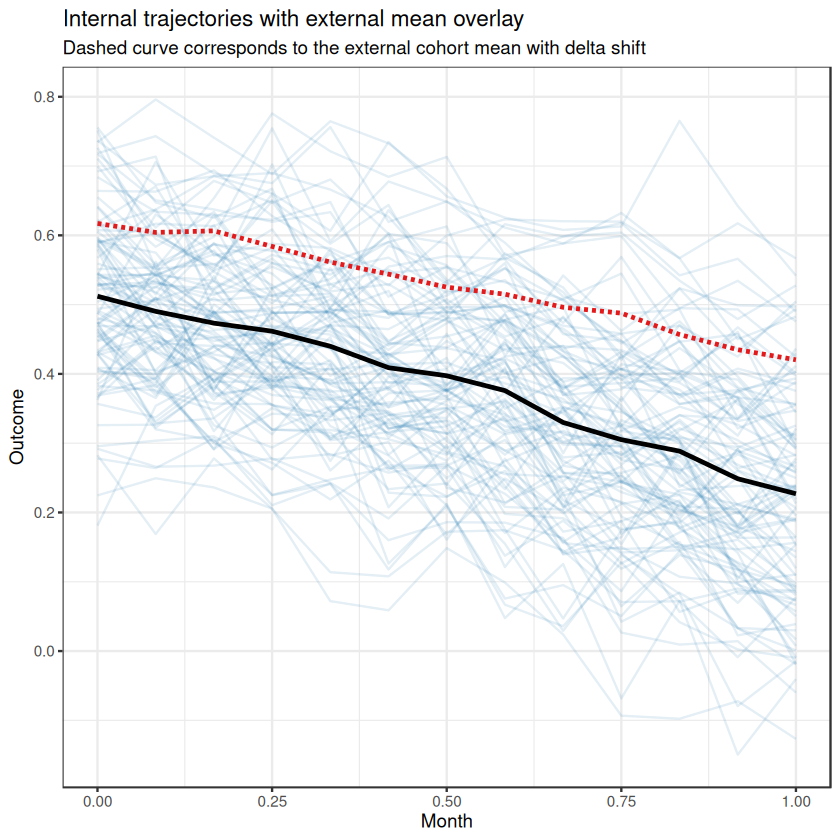

In [8]:
trajectory_internal <- purrr::map_dfr(seq_along(x), function(k) {
  tibble(
    patient = seq_len(design$J_internal),
    month = x[k],
    y = internal$y[, k]
  )
})

ggplot() +
  geom_line(data = trajectory_internal, aes(month, y, group = patient), alpha = 0.12, colour = "#1f78b4") +
  geom_line(data = visit_grid, aes(month, internal_mean), colour = "black", linewidth = 1) +
  geom_line(data = visit_grid, aes(month, external_mean), colour = "#e31a1c", linewidth = 1, linetype = "dashed") +
  labs(x = "Month", y = "Outcome",
       title = "Internal trajectories with external mean overlay",
       subtitle = "Dashed curve corresponds to the external cohort mean with delta shift") +
  theme_bw()


## Stan data lists

As in `linear_baad.R`, the Stan program expects both raw data and the Monte Carlo seeds (`xi`) used for the simulated-average likelihood.

In [9]:
stan_base <- list(
  fit_all = 0L,
  fit_local = 0L,
  J = design$J_internal,
  T = length(x),
  K = 2L,
  K_phi = 6L,
  y = internal$y,
  J_prime = design$J_external,
  T_prime = length(x),
  y_prime = external$y,
  x = x,
  x_prime = x,
  mu_phi_p = rep(0, 6),
  Sigma_phi_p = diag(rep(1, 6)),
  mu_delta_p = rep(0, 2),
  Sigma_delta_p = diag(rep(1, 2)),
  J_tilde = 500L,
  C = 4L,
  xi = array(rnorm(4L * 2L * (2L * 500L)), dim = c(4L, 2L, 2L * 500L))
)

local_data <- stan_base
local_data$fit_local <- 1L

approx_data <- stan_base
approx_data$fit_all <- 0L

integrated_data <- stan_base
integrated_data$fit_all <- -1L

full_data <- stan_base
full_data$fit_all <- 1L

list(
  y_dims = dim(stan_base$y),
  y_prime_dims = dim(stan_base$y_prime),
  J_tilde = stan_base$J_tilde,
  xi_dims = dim(stan_base$xi)
)


$y_dims
[1] 100  13

$y_prime_dims
[1] 100  13

$J_tilde
[1] 500

$xi_dims
[1]    4    2 1000

## Stan program

The chunk below copies `linear_mvn_approx.stan` into a post-specific directory so the notebook stays reproducible even if the upstream file changes.

In [ ]:
stan_dir <- file.path("content", "posts", "pkpd", "stan")
if (!dir.exists(stan_dir)) dir.create(stan_dir, recursive = TRUE)
stan_path <- file.path(stan_dir, "meta202_linear.stan")
file.copy(file.path("content", "baad-master", "linear_mvn_approx.stan"), stan_path, overwrite = TRUE)
stan_path


[1] FALSE

[1] "content/posts/pkpd/stan/meta202_linear.stan"

In [ ]:
meta202_model <- rstan::stan_model(stan_path)
meta202_model


Warning message in normalizePath(file):
“path[1]="content/posts/pkpd/stan/meta202_linear.stan": No such file or directory”
Warning message in file(fname, "rt"):
“cannot open file 'content/posts/pkpd/stan/meta202_linear.stan': No such file or directory”


Error in file(fname, "rt") : cannot open the connection


ERROR: Error in get_model_strcode(file, model_code): cannot open model file "content/posts/pkpd/stan/meta202_linear.stan"


## Inference scenarios

Set `run_sampling <- TRUE` after configuring Stan to fit the four cases discussed in the article: `local`, `approximate`, `integrated`, and `full`.

In [ ]:
run_sampling <- FALSE

if (run_sampling) {
  sampling_args <- list(
    object = meta202_model,
    iter = 2000,
    warmup = 1000,
    chains = 4,
    refresh = 500,
    chain_id = 1L
  )
  fits <- list(
    local = do.call(rstan::sampling, c(list(data = local_data), sampling_args)),
    approximate = do.call(rstan::sampling, c(list(data = approx_data), sampling_args)),
    integrated = do.call(rstan::sampling, c(list(data = integrated_data), sampling_args)),
    full = do.call(rstan::sampling, c(list(data = full_data), sampling_args))
  )
} else {
  message("Sampling skipped. Set `run_sampling <- TRUE` once rstan is configured.")
}


In [ ]:
if (exists("fits")) {
  parameters_of_interest <- true_values$parameter
  summaries <- purrr::imap_dfr(fits, function(fit, label) {
    draws <- posterior::as_draws_df(fit, variables = parameters_of_interest)
    posterior::summarise_draws(draws,
      mean = mean,
      sd = sd,
      q05 = ~posterior::quantile2(.x, 0.05),
      q95 = ~posterior::quantile2(.x, 0.95)
    ) %>%
      mutate(model = label)
  })
  summaries %>%
    dplyr::left_join(true_values, by = c("variable" = "parameter")) %>%
    dplyr::relocate(model)
} else {
  true_values
}
